# COVID-19 Literature Clustering

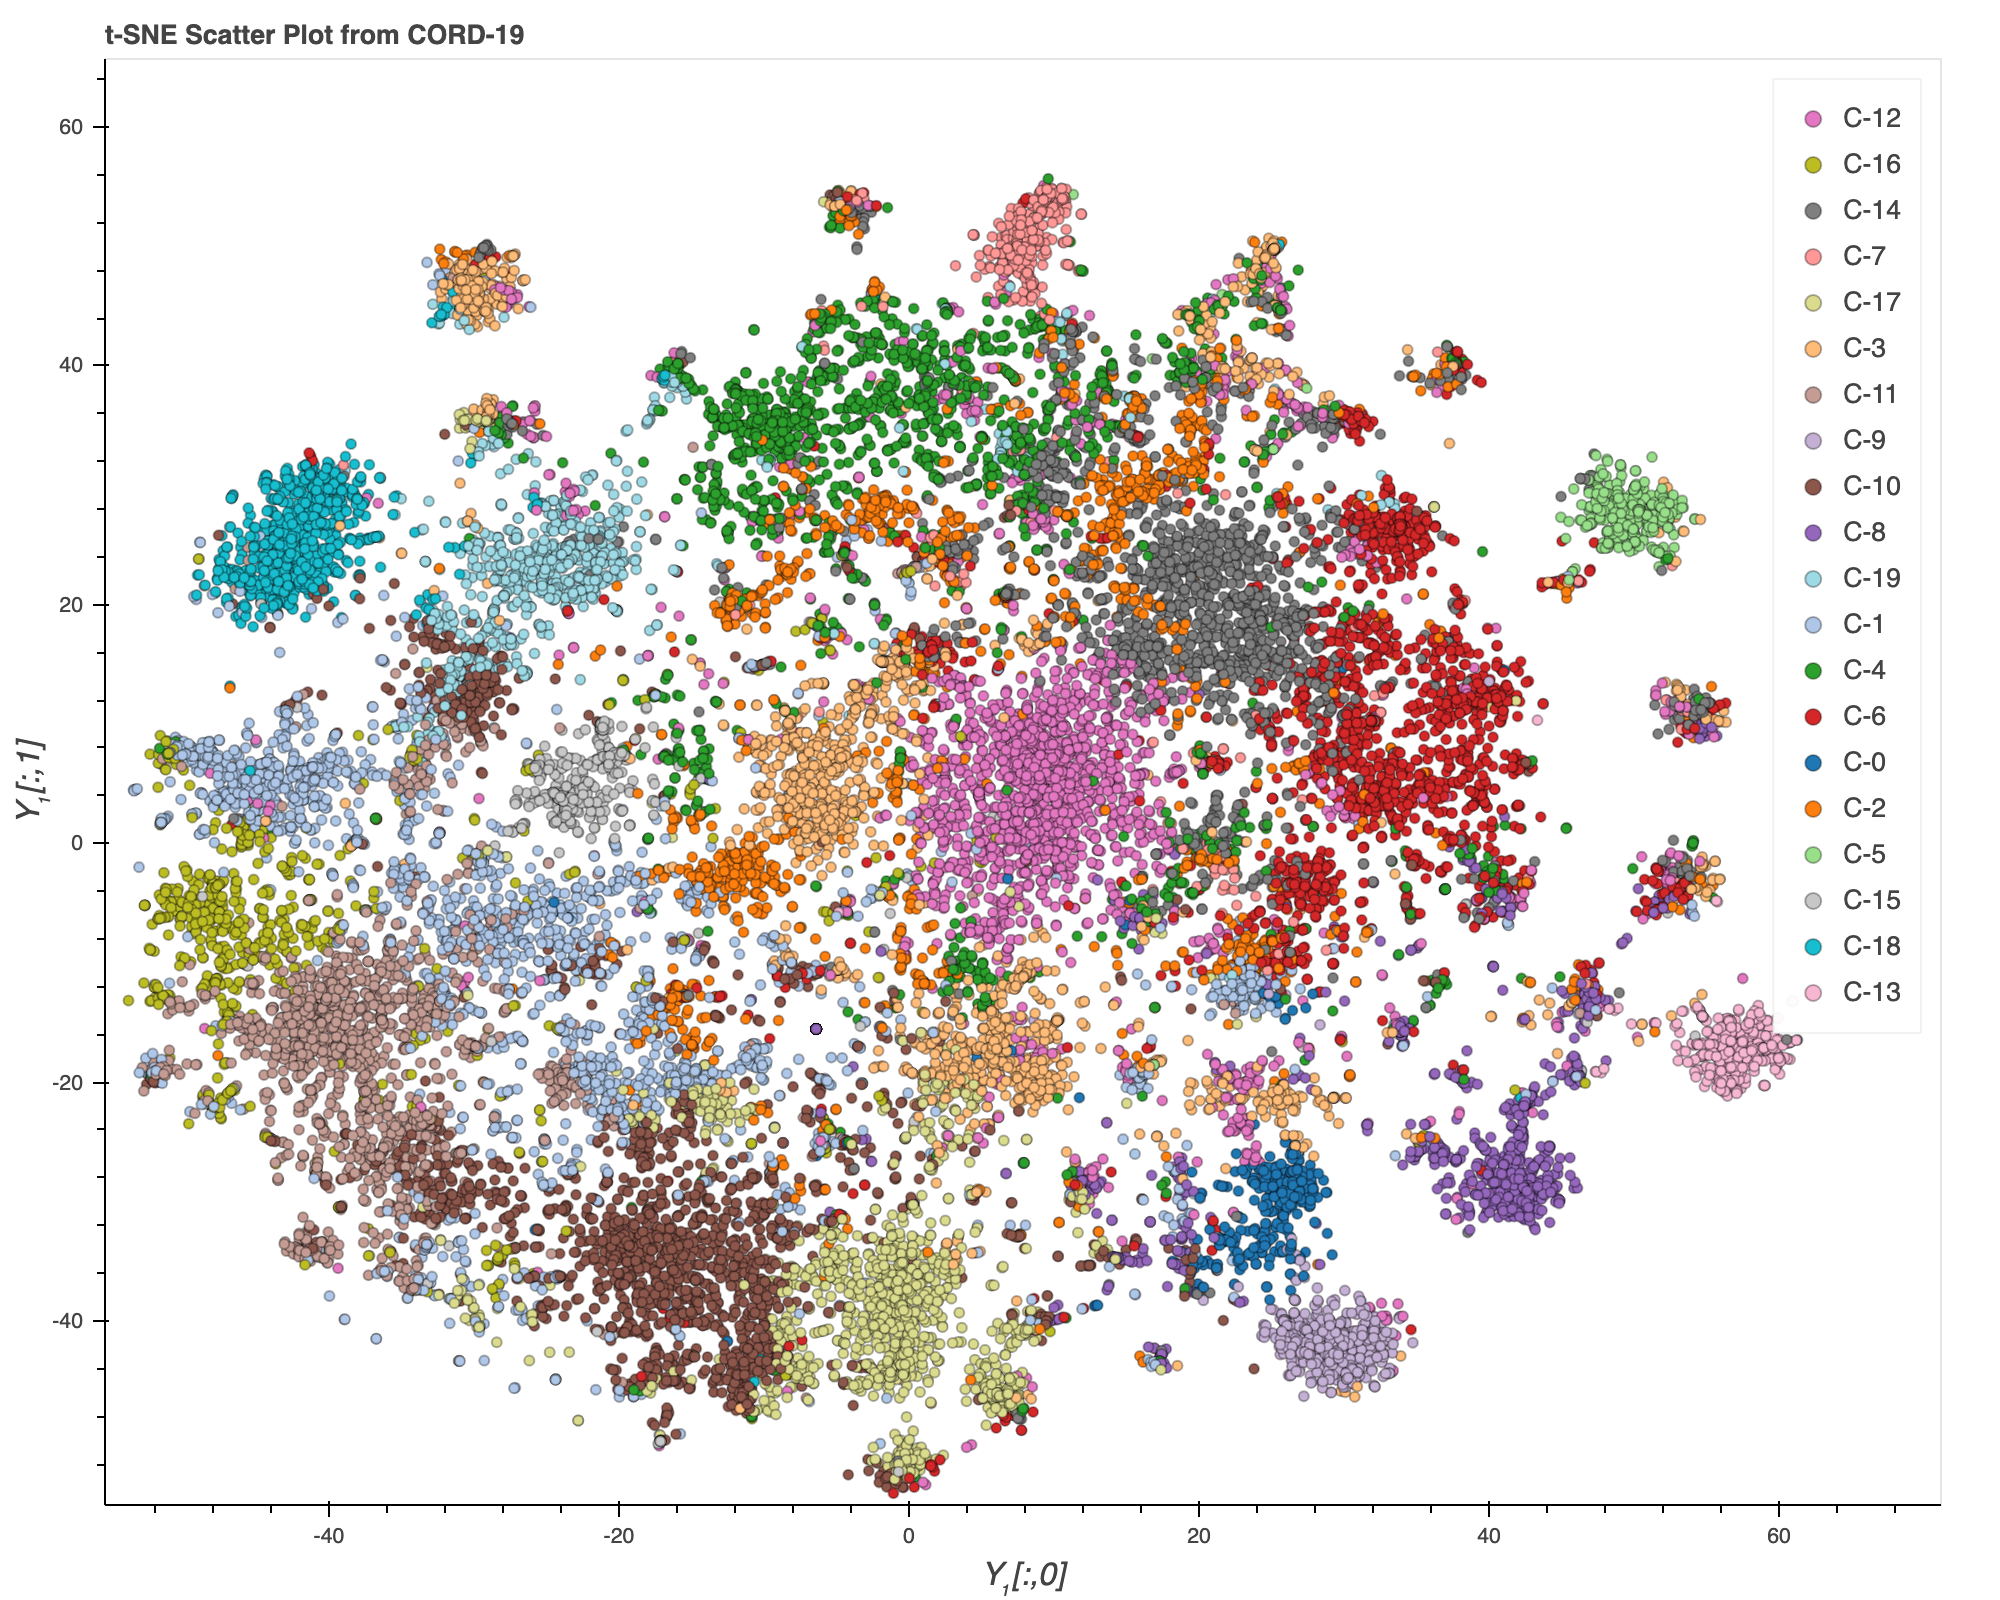

In [6]:
from IPython.display import Image
Image(filename='kaggle-resources/bokeh_plot.png', width=800, height=800)

<h2 style="color:red;">You can find the full version of the interactive plot here on GitHub:</h2>

### https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html
Because of its size, a sparse version is produced in this Notebook.
<br>
<br>

<h2 style="color:black;">Link to poster:</h2>
coming soon
<br>
<br>

## How to Cite This Work?
```
@inproceedings{COVID-19 Literature Clustering,
	author = {Eren, E. Maksim. Solovyev, Nick. Nicholas, Charles. Raff, Edward},
	title = {COVID-19 Literature Clustering},
	year = {2020},
	month = {April},
	location = {University of Maryland Baltimore County (UMBC), Baltimore, MD, USA},
	note={Malware Research Group},
	url = {\url{https://github.com/MaksimEkin/COVID19-Literature-Clustering}},
    howpublished = {TBA}
}
```

# Goal
Given the large number of literature and the rapid spread of COVID-19, it is difficult for health professionals to keep up with new information on the virus. Can clustering similar research articles together simplify the search for related publications? How can the content of the clusters be qualified?

By using clustering for labelling in combination with dimensionality reduction for visualization, the collection of literature can be represented by a scatter plot. On this plot, publications of highly similar topic will share a label and will be plotted near each other. In order, to find meaning in the clusters, topic modelling will be performed to find the keywords of each cluster.

By using Bokeh, the plot will be interactive. User’s will have the option of seeing the plot as a whole or filtering the data by cluster. If a narrower scope is required, the plot will also have a search function which will limit the output to only papers containing the search term. Hovering over points on the plot will give basic information like title, author, journal, and abstract. Clicking on a point will bring up a menu with a URL that can be used to access the full publication.

This is a difficult time in which health care workers, sanitation staff, and many other essential personnel are out there keeping the world afloat. While adhering to quarantine protocol, the Kaggle CORD-19 competition has given us an opportunity to help in the best way we can as computer science students. It should be noted, however, that we are not epidemiologists, and it is not our place to gauge the importance of these papers. This tool was created to help make it easier for trained professionals to sift through many, many publications related to the virus, and find their own determinations.

#### We welcome feedback so that we can continue to improve this project.

<br>
<br>

# Approach:

- Parse the text from the body of each document using Natural Language Processing (NLP).
- Turn each document instance $d_i$ into a feature vector $X_i$ using Term Frequency–inverse Document Frequency (TF-IDF).
- Apply Dimensionality Reduction to each feature vector $X_i$ using t-Distributed Stochastic Neighbor Embedding (t-SNE) to cluster similar research articles in the two dimensional plane $X$ embedding $Y_1$.
- Use Principal Component Analysis (PCA) to project down the dimensions of $X$ to a number of dimensions that will keep .95 variance while removing noise and outliers in embedding $Y_2$.
- Apply k-means clustering on $Y_2$, where $k$ is 20, to label each cluster on $Y_1$.
- Apply Topic Modeling on $X$ using Latent Dirichlet Allocation (LDA) to discover keywords from each cluster. 
- Investigate the clusters visually on the plot, zooming down to specific articles as needed, and via classification using Stochastic Gradient Descent (SGD). 

<br>

# Table of Contents
1. Loading the data
2. Pre-processing
3. Vectorization
4. PCA  & Clustering
5. Dimensionality Reduction with t-SNE
6. Topic Modeling on Each Cluster
7. Classify
8. Plot
9. How to Use the Plot?
10. Conclusion
11. Citation/Sources

<br>

### Dataset Description

>In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 51,000 scholarly articles, including over 40,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up.
>#### Cite: [COVID-19 Open Research Dataset Challenge (CORD-19) | Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) 
> #### Kaggle Submission: [COVID-19 Literature Clustering | Kaggle](https://www.kaggle.com/maksimeren/covid-19-literature-clustering#Unsupervised-Learning:-Clustering-with-K-Means)

<br>

# Loading the Data
Load the data following the notebook by Ivan Ega Pratama, from Kaggle.
#### Cite: [Dataset Parsing Code | Kaggle, COVID EDA: Initial Exploration Tool](https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool)

### Loading Metadata

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

Let's load the metadata of the dateset. 'title' and 'journal' attributes may be useful later when we cluster the articles to see what kinds of articles cluster together.

In [4]:
root_path = 'CORD-19-research-challenge/'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,arxiv_id,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,zjufx4fo,b2897e1277f56641193a6db73825f707eed3e4c9,PMC,Sequence requirements for RNA strand transfer ...,10.1093/emboj/20.24.7220,PMC125340,11742998,unk,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,"Pasternak, Alexander O.; van den Born, Erwin; ...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125340?pdf=re...
1,ymceytj3,e3d0d482ebd9a8ba81c254cc433f314142e72174,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",10.1093/emboj/21.9.2076,PMC125375,11980704,unk,CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,"Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125375?pdf=re...
2,wzj2glte,00b1d99e70f779eb4ede50059db469c65e8c1469,PMC,Synthesis of a novel hepatitis C virus protein...,10.1093/emboj/20.14.3840,PMC125543,11447125,no-cc,Hepatitis C virus (HCV) is an important human ...,2001-07-16,"Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...",EMBO J,NaN,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,2sfqsfm1,cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0,PMC,Structure of coronavirus main proteinase revea...,10.1093/emboj/cdf327,PMC126080,12093723,unk,The key enzyme in coronavirus polyprotein proc...,2002-07-01,"Anand, Kanchan; Palm, Gottfried J.; Mesters, J...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc126080?pdf=re...
4,i0zym7iq,dde02f11923815e6a16a31dd6298c46b109c5dfa,PMC,Discontinuous and non-discontinuous subgenomic...,10.1093/emboj/cdf635,PMC136939,12456663,unk,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,"van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc136939?pdf=re...


In [ ]:
meta_df.info()

### Fetch All of JSON File Path

Get path to all JSON files:

In [ ]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

### Helper Functions

 File Reader Class

In [ ]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            if 'abstract' in content.keys():
                for entry in content['abstract']:
                    self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

Helper function adds break after every words when character length reach to certain amount. This is for the interactive plot so that hover tool fits the screen.

In [ ]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

### Load the Data into DataFrame

Using the helper functions, let's read in the articles into a DataFrame that can be used easily:

In [ ]:
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0:
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

## Some feature engineering
Adding word count columns for both abstract and body_text can be useful parameters later:

In [ ]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

In [ ]:
df_covid.info()

In [ ]:
df_covid['abstract'].describe(include='all')

## Handle Possible Duplicates

When we look at the unique values above, we can see that tehre are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicats from our dataset:

(Thank you Desmond Yeoh for recommending the below approach on Kaggle)

In [ ]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

In [ ]:
df_covid['body_text'].describe(include='all')

It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

## Take a Look at the Data:

__[Task 2: Add papers related to the chosen software from last weeK]__
- get word count for abstract and body
- get number of unique words for body
- handle possible duplicates

In [ ]:
# 1
f = open('Data_Collection/Task_2/MasterRegulator.txt', 'r')
content_new = f.readlines()
s = '' 
for v in content_new:
    s += v

# 2
paper_id_new = ['new_paper']
doi_new = ['10.3390/jcm9040982']
abstract_new = ['The recent epidemic outbreak of a novel human coronavirus called SARS-CoV-2 causing the respiratory tract disease COVID-19 has reached worldwide resonance and a global effort is being undertaken to characterize the molecular features and evolutionary origins of this virus. In this paper, we set out to shed light on the SARS-CoV-2/host receptor recognition, a crucial factor for successful virus infection. Based on the current knowledge of the interactome between SARS-CoV-2 and host cell proteins, we performed Master Regulator Analysis to detect which parts of the human interactome are most affected by the infection. We detected, amongst others, affected apoptotic and mitochondrial mechanisms, and a downregulation of the ACE2 protein receptor, notions that can be used to develop specific therapies against this new virus.']
# 5
body_text_new = [s]
# 6
authors_new = ['Pietro H. Guzzi, Daniele Mercatelli, Carmine Ceraolo, Federico M. Giorgi']
title_new = ['Master Regulator Analysis of the SARS-CoV-2/Human Interactome']
journal_new = ['Journal of Clinical Medicine']
#7
df_covid = df_covid.append(pd.DataFrame([[paper_id_new[0], doi_new[0], abstract_new[0], body_text_new[0], 
                                          authors_new[0], title_new[0], journal_new[0], 
                                          get_breaks(' '.join(abstract_new[0].split(' ')[:100]),40), 
                                          len(abstract_new[0].strip().split()), 
                                          len(body_text_new[0].strip().split()), 
                                          len(set(str(body_text_new[0]).split()))]], 
                                        columns=list(df_covid.columns)), ignore_index=True)



In [ ]:
df_covid.tail()

In the majority of this notebook we will be working with **body_text** <br>
Links to the papers will be generated using **doi** 

In [ ]:
df_covid.describe()

# Data Pre-processing

Unfortunately, running the next steps of the notebook is not possible on the full dataset within Kaggle. The full plot is available is at https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html.

In Kaggle we will limit the dataframe to **10,000** instances

__[Task 2: Ensure, the added paper is in df]__

In [ ]:
df = df_covid.sample(10000, random_state=42)
if not 'new_paper' in df.paper_id.values:
    df = df.append(df_covid.tail(1), ignore_index=True)
del df_covid

Now that we have our dataset loaded, we need to clean-up the text to improve any clustering or classification efforts. First, let's drop Null vales:

In [ ]:
df.dropna(inplace=True)
df.info()

### Handling multiple languages
Next we are going to determine the language of each paper in the dataframe. Not all of the sources are English and the language needs to be identified so that we know how handle these instances

In [ ]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

In [ ]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Lets take a look at the language distribution in the dataset

In [ ]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()


We will be dropping any language that is not English. Attempting to translate foreign texts gave the following problems:

1. API calls were limited

2. Translating the language may not carry over the true semantic meaning of the text


In [ ]:
df = df[df['language'] == 'en'] 
df.info()

In [ ]:
# Download the spacy bio parser

from IPython.utils import io
with io.capture_output() as captured:
    !pip3.7 install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [ ]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

### Stopwords

Part of the preprocessing will be finding and removing stopwords (common words that will act as noise in the clustering step).

In [ ]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

Now the above stopwords are used in everyday english text. Research papers will often frequently use words that don't actually contribute to the meaning and are not considered everyday stopwords.

Thank you Daniel Wolffram for the idea.
#### Cite: [Custom Stop Words | Topic Modeling: Finding Related Articles](https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles)

In [ ]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Next lets create a function that will process the text data for us. 
For this purpose we will be using the spacy library. This function will convert text to lower case, remove punctuation, and find and remove stopwords. For the parser, we will use en_core_sci_lg. This is a model for processing biomedical, scientific or clinical text.

In [ ]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

Applying the text-processing function on the **body_text**. 

In [ ]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

### Let's take a look at word count in the papers

In [ ]:
import seaborn as sns

In [ ]:
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

In [ ]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

These two plots give us a good idea of the content we are dealing with. Most papers are about 5000 words in length. The long tails in both plots are caused by outliers. In fact, ~98% of the papers are under 20,000 words in length while a select few are over 200,000! <br><br>

# Vectorization

Now that we have pre-processed the data, it is time to convert it into a format that can be handled by our algorithms. For this purpose we will be using tf-idf. This will convert our string formatted data into a measure of how important each word is to the instance out of the literature as a whole.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

Vectorize our data. We will be clustering based off the content of the body text. The maximum number of features will be limited. Only the top 2 ** 12 features will be used, eseentially acting as a noise filter. Additionally, more features cause painfully long runtimes.

In [ ]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

# PCA  & Clustering

Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means. Note that X_reduced will only be used for k-means, t-SNE will still use the original feature vector X that was generated through tf-idf on the NLP processed text.

(Thank you Dr. Edward Raff for the suggestion)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

To separate the literature, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
Image(filename='kaggle-resources/kmeans.PNG', width=800, height=800)

[source](https://en.wikipedia.org/wiki/K-means_clustering)

### How many clusters? 

To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.

In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

In [ ]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In this plot we can see that the better k values are between 18-25. After that, the decrease in distortion is not as significant. For simplicity, we will use k=20

### Run k-means

Now that we have an appropriate k value, we can run k-means on the PCA-processed feature vector (X_reduced). 

In [ ]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

# Dimensionality Reduction with t-SNE

Using [t-SNE](https://lvdmaaten.github.io/tsne) we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the body_text can be plotted. 

> t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space
> #### Cite: [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow: Second Edition | Aurélien Geron](https://github.com/ageron/handson-ml2)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

So that step took a while! Let's take a look at what our data looks like when compressed to 2 dimensions. 

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("Data_Collection/Task_2/t-sne_covid19_Task_2.png")
plt.show()

This looks pretty bland. There are some clusters we can immediately detect, but the many instances closer to the center are harder to separate. t-SNE did a good job at reducing the dimensionality, but now we need some labels. Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics.

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("Data_Collection/Task_2/improved_cluster_tsne_Task_2.png")
plt.show()

The labeled plot gives better insight into how the papers are grouped. It is interesting that both k-means and t-SNE are able to agree on certain clusters even though they were ran independetly. The location of each paper on the plot was determined by t-SNE while the label (color) was determined by k-means. If we look at a particular part of the plot where t-SNE has grouped many articles forming a cluster, it is likely that k-means is uniform in the labeling of this cluster (most of the cluster is the same color). This behavior shows that structure within the literature can be observed and measured to some extent. 

Now there are other cases where the colored labels (k-means) are spread out on the plot (t-SNE). This is a result of t-SNE and k-means finding different connections in the higher dimensional data. The topics of these papers often intersect so it hard to cleanly separate them. This effect can be observed in the formation of subclusters on the plot. These subclusters are a conglomeration of different k-means labels but may share some connection determined by t-SNE.

This organization of the data does not act as a simple search engine. The clustering + dimensionality reduction is performed on the mathematical similarities of the publications. As an unsupervised approach, the algorithms may even find connections that were unnaparent to humans. This may highlight hidden shared information and advance further research.


# Topic Modeling on Each Cluster

Now we will attempt to find the most significant words in each clusters. K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

For topic modeling, we will use LDA (Latent Dirichlet Allocation). In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words[.](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
Image(filename='kaggle-resources/lda.jpg', width=600, height=600)

[source](https://towardsdatascience.com/latent-dirichlet-allocation-15800c852699)

First we will create 20 vectorizers, one for each of our cluster labels

In [ ]:
vectorizers = []
    
for ii in range(0, 20):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [ ]:
vectorizers[0]

Now we will vectorize the data from each of our clusters

In [ ]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [ ]:
len(vectorized_data)

Topic modeling will be performed through the use of Latent Dirichlet Allocation (LDA). This is a generative statistical model that allows sets of words to be explained by a shared topic

In [ ]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

In [ ]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Extracts the keywords from each cluster

In [ ]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

In [ ]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [ ]:
all_keywords[0][:10]

In [ ]:
len(all_keywords)

### Save current outputs to file

Re-running some parts of the notebook (especially vectorization and t-SNE) are time intensive tasks. We want to make sure that the important outputs for generating the bokeh plot are saved for future use.

In [ ]:
f=open('Data_Collection/Task_2/topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [ ]:
import pickle

# save the COVID-19 DataFrame, too large for github
pickle.dump(df, open("Data_Collection/Task_2/df_covid.p", "wb" ))

# save the final t-SNE
pickle.dump(X_embedded, open("Data_Collection/Task_2/X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("Data_Collection/Task_2/y_pred.p", "wb" ))

# Classify

Though arbitrary, after running kmeans, the data is now 'labeled'. This means that we now use supervised learning to see how well the clustering generalizes. This is just one way to evaluate the clustering. If k-means was able to find a meaningful split in the data, it should be possible to train a classifier to predict which cluster a given instance should belong to. 

In [ ]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

Let's split the data into train/test sets

In [ ]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

**Precision** is ratio of True Positives to True Positives + False Positives. This is the accuracy of positive predictions<br>
**Recall** (also known as TPR) measures the ratio of True Positives to True Positives + False Negatives. It measures the ratio of positive instances that are correctly detected by the classifer.<br>
**F1 score**  is the harmonic average of the precision and recall. F1 score will only be high if both precision and recall are high

#### Cite: [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow: Second Edition | Aurélien Geron](https://github.com/ageron/handson-ml2) 

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

To test for overfitting, let's see how the model generalizes over the test set

In [ ]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

Now let's see how the model can generalize across the whole dataset.

In [ ]:
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

# Plotting the data
The previous steps have given us clustering labels and a dataset of papers reduced to two dimensions. By pairing this with Bokeh, we can create an interactive plot of the literature. This should organize the papers such that related publications are in close proximity. To try to undertstand what the similarities may be, we have also performed topic modelling on each cluster of papers in order to pick out the key terms.

Bokeh will pair the actual papers with their positions on the t-SNE plot. Through this approach it will be easier to see how papers fit together, allowing for both exploration of the dataset and evaluation of the clustering. 

In [ ]:
import os

# change into lib directory to load plot python scripts
main_path = os.getcwd()
lib_path = 'kaggle-resources/'
os.chdir(lib_path)

In [ ]:
!pip3.7 install 'bokeh==1.3.4'

In [ ]:
# required libraries for plot
from call_backs import input_callback, selected_code  # file with customJS callbacks for bokeh
                                                      # github.com/MaksimEkin/COVID19-Literature-Clustering/blob/master/lib/call_backs.py
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

In [ ]:
print(bokeh.__version__)


In [ ]:
# go back
os.chdir(main_path)

## Load the Keywords per Cluster

In [ ]:
import os

topic_path = 'Data_Collection/Task_2/topics.txt'
with open(topic_path) as f:
    topics = f.readlines()

## Setup

In [ ]:
# show on notebook
output_notebook()
# target labels
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df['title'],
    authors = df['authors'],
    journal = df['journal'],
    abstract = df['abstract_summary'],
    labels = ["C-" + str(x) for x in y_labels],
    links = df['doi']
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors{safe}"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
    ("Link", "@links")
],
point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering of the COVID-19 Literature with t-SNE and K-Means", 
           toolbar_location="above")

# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')
plot.legend.background_fill_alpha = 0.6

## Widgets
see https://github.com/MaksimEkin/COVID19-Literature-Clustering/issues/6 to solve widget callback attribute error

In [ ]:
# Keywords
text_banner = Paragraph(text= 'Keywords: Slide to specific cluster to see the keywords.', height=45)
input_callback_1 = input_callback(plot, source, text_banner, topics)

# currently selected article
div_curr = Div(text="""Click on a plot to see the link to the article.""",height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr), code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

# WIDGETS
slider = Slider(start=0, end=20, value=20, step=1, title="Cluster #", callback=input_callback_1 )
keyword = TextInput(title="Search:", callback=input_callback_1)


# pass call back arguments
input_callback_1.args["text"] = keyword
input_callback_1.args["slider"] = slider

## Style

In [ ]:
# STYLE
slider.sizing_mode = "stretch_width"
slider.margin=15

keyword.sizing_mode = "scale_both"
keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.sizing_mode = "scale_both"
text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 5

r = row(div_curr,text_banner)
r.sizing_mode = "stretch_width"

## SHOW

In [ ]:
# LAYOUT OF THE PAGE
l = layout([
    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot],
])
l.sizing_mode = "scale_both"

# show
output_file('Data_Collection/Task_2/t-sne_covid-19_interactive_Task_2.html')
show(l)

# How to Use the Plot?

Each dot on the plot represents a research article. They are color-coded by the cluster number that kmeans had found. By default no cluster is selected and all the clusters are displayed. To select a distinct cluster, set the slider to the desired cluster number. When an individual cluster is selected, a list of keywords found in that cluster will be displayed above the plot.You can also search for articles by specific keyword, either within an individual cluster or within all. Let's go through an example of how the tool can be used. 

**Note, This example is pulled from the full plot, available at:** <br>
https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html

First let's check out the different clusters and see if anything interesting stands out. The easiest way to get a general idea of what is going on in each cluster is to look to the keywords for each cluster (the ones we identified through topic modeling). For the sake of example, let's say we see some keywords that interest us in cluster #9. This cluster seems to center around livestock

In [ ]:
Image(filename="kaggle-resources/cluster_9_keywords.PNG", width=1170, height=60)

<br>

And here is what the actual cluster looks like, zoomed in on the plot:

In [ ]:
Image(filename='kaggle-resources/cluster_9.PNG', width=420, height=375)

Now let's say we interested specifically in cattle. Let's use the keyword search to filter for papers that specifically mention cattle. This is what the same cluster will look like now:

In [ ]:
Image(filename='kaggle-resources/cluster_9_cattle.PNG', width=420, height=375)

The shown articles are now a little thinner, showing only papers that are part of the cluster and that contain the keyword 'cattle'. The search can also be expanded to the entire dataset by setting the # of clusters to the default value of 20. Hovering over any article will give basic information like title, author, and abstract. Clicking on an article will pin that article above the plot and give a URL that will direct the user to the full paper. Here's what clicking an article looks like:

In [ ]:
Image(filename='kaggle-resources/selected_paper.PNG', width=600, height=100)

# Examples

*Note: We will be using the [full plot](https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html) for these examples*

The plot can be used to quickly find many publications on a similar topic. For example, let's say we're interested in finding information on masks and their effectiveness. To do this we can either try to find a cluster with a keyword such as "mask" or we can search for the term directly and try to identify which cluster it most closely relates to. 

If you search for "mask", a dark green cluster (#12) is well represented. It would be wise to start the looking there. A quick scan of the titles indicates that these publications mainly address different masks and their uses for healthcare workers. 

Searching for a single key term may cause you to inadvertenly filter out highly similar papers that use different phrasing. After an initial examination, clear the search term and explore the whole cluster by adjusting the slider. In this case, we would set the slider to 12 and look for more interesting papers in the entire cluster.

Now we will explore a couple task-oriented questions.

## What do we know about diagnostics and surveillance?

### Diagnostics
- To start, we first searched one of the keyterms from this question ("diagnostic")
- For "diagnostic", the brown cluster (#17) stood out immediately
- Next we removed the search term and adjusted the slider to 17
- Inside cluster 17 there exists a main cluster and a smaller, denser sub-cluster just off to the right of the main one. Both this main cluster and the sub-cluster seem to contain useful information on diagnosing viral infections. Just quickly skimming through the publications, we saw papers such as:

    - [Evaluation of fast-track diagnostics and TaqMan array card real-time PCR assays for the detection of respiratory pathogens](https://www.sciencedirect.com/science/article/pii/S0167701214002991?via%3Dihub) 
    - [Advances in the diagnosis of respiratory virus infections](https://www.sciencedirect.com/science/article/pii/0928019796002103?via%3Dihub) 

### Surveillance 
- Next, we returned to the full plot by adjusting the slider to cluster 20 (clusters range from 0 to 19; 20 plots all)
- We then repeated the search process with keyterm "surveillance"
- The dominant cluster for this search term was cluster #8. After clearing the search box and adjusting the slider to 8, we looked at some of the titles and abstracts in this cluster
- A couple that stood out: 

    - [Surveillance strategy for early detection of unusual infectious disease events](https://www.sciencedirect.com/science/article/pii/S1879625713000217?via%3Dihub)  
    - [Communicable Disease Surveillance Ethics in the Age of Big Data and New Technology](https://link.springer.com/article/10.1007/s41649-019-00087-1)

<br>
## What do we know about vaccines and therapeutics?

### Vaccine
- To identify which cluster to examine first for papers on vaccines, we used a different strategy than before
- By examinining the keywords generated through topic modeling for each cluster, we found that cluster #15 had related keywords like "vaccine", "serum", and "delivery"
- To further verify, we also searched for "vaccine" within the whole dataset and found that cluster #15 was well represented
- While exploring this cluster we ran into an issue of overrepresentation - many publications focused on vaccines that seemed unrelated. To remedy this we searched for "corona" within the cluster
- This narrowed down the publications and made it easier to look for interesting papers. Here are a few that we found:

    - [Development of next-generation respiratory virus vaccines through targeted modifications to viral immunomodulatory genes](https://www.tandfonline.com/doi/full/10.1586/14760584.2015.1095096)
    - [Intranasal DNA Vaccine for Protection against Respiratory Infectious Diseases: The Delivery Perspectives](https://www.mdpi.com/1999-4923/6/3/378)

### Therapeutics
- Cluster #1 has more information on vaccine/therapeutics
- Specifically, there is a lot of information on coronaviruses (the top keyword in the cluster is MERS)
- A few interesting papers from cluster #1:

    - [A safe and convenient pseudovirus-based inhibition assay to detect neutralizing antibodies and screen for viral entry inhibitors against the novel human coronavirus MERS-CoV](https://virologyj.biomedcentral.com/articles/10.1186/1743-422X-10-266)
    - [Advances in MERS-CoV Vaccines and Therapeutics Based on the Receptor-Binding Domain](https://www.mdpi.com/1999-4915/11/1/60)
    
<br>


# Conclusion
In this project, we have attempted to cluster published literature on COVID-19 and reduce the dimensionality of the dataset for visualization purposes. This has allowed for an interactive scatter plot of papers related to COVID-19, in which material of similar theme is grouped together. Grouping the literature in this way allows for professionals to quickly find material related to a central topic. Instead of having to manually search for related work, every publication is connected to a larger topic cluster. The clustering of the data was done through k-means on a pre-processed, vectorized version of the literature’s body text. As k-means simply split the data into clusters, topic modeling through LDA was performed to identify keywords. This gave the topics that were prevalent in each of the clusters. Both the clusters and keywords are found through unsupervised learning models and can be useful in revealing patterns that humans may not have even thought about. In no part of this project did we have to manually organize the papers: the results are due to latent connections in the data. 
 
K-means (represented by colors) and t-SNE (represented by points) were able to independently find clusters, showing that relationships between papers can be identified and measured. Papers written on highly similar topics are typically near each other on the plot and bear the same k-means label. However, due to the complexity of the dataset, k-means and t-SNE will sometimes arrive at different decisions. The topics of much of the given literature are continuous and will not have a concrete decision boundary. This means that k-means and t-SNE can find different similarities to group the papers by. In these conditions, our approach performs quite well.

As this is an unsupervised learning problem, the evaluation of our work was not an exact science. First, the plot was examined to assert that clusters were actually being formed. After being convinced of this, we examined the titles/abstracts of some of the papers in different clusters. For the most part, similar research areas were clustered. Our last evaluation method was classification. By training a classification model with the k-means labels and then testing it on a separate subset of the data, we could see that the clustering was not completely arbitrary as the classifier performed well. 

Our manual inspection of the documents was quite limited, as neither of the authors are qualified to assess the meaning of the literature. Even so, it was apparent that articles on key topics could be easily found in close proximity to each other. For example, searching for 'mask' can reveal a sub cluster of papers that evaluate the efficacy of masks.  We believe that health professionals can use this tool to find real links in the texts. By organizing the literature, qualified people can quickly find related publications that answer the task questions. This project can further be improved by abstracting the underlying data analysis techniques as described in this notebook to develop a user interface/tool that presents the related articles in a user-friendly manner.


<br>
<br>
<br>

**Some areas we thought were great:** (pros)
- The tool is saved as an html file. It can be downloaded and used locally/offline.
- It is portable/mobile, easily deployable, and failover safe; the risk of denial of service in the case of emergencies such as the loss of network connection is mitigated
- Dimensionality reduction allows for the whole dataset to be easily accessible. The papers are all up on the plot and can be quickly examined by hovering over them. If the abstract seems interesting, the user can click on the point to bring up a text box with more information that will contain a link to the full paper
- Patterns in the data found through clustering/dimensionality reduction may not be readily apparent to researchers. These unsupervised techniques can show humans hidden connnections in the literature
- If the topics/clusters are not narrow enough for the user, a search for a key term that will only bring up papers that contain the search term. Search can be performed inside of a selected cluster or the entire dataset if preferred. This increases the flexibility of how patterns can be discovered.
- A surface level examination of the plot showed some very interesting organization of the data. For example, one subcluster consisted of papers that tried to determine the efficacy of masks in preventing the spread of COVID-19.
- Once the models are trained, the results can be generated in constant time.
- This work can be easily replicated and modified as needed, serving as a foundation for future projects.

<br>

**Future thoughts to consider:** (cons)
- Possible false positives, difficult to draw an exact line between subjects
- K-means and t-SNE are unsupervised approaches that will not necessarily group instances in a predictable way. Due to their unsupervised nature, there is no 'right answer' for how the papers should be clustered. This could be difficult to debug if problems arise.
- Loss of foreign language papers. This leads to the loss of experience from different geographic locations on dealing with COVID-19
- The algorithms used in this notebook are stochastic so the results may vary depending on the random state. In this notebook all of the algorithms are set to random state 42 (the meaning of life) to ensure reproducible results
- Long run time to train models on large dataset of literature

# Citation/Sources

Kaggle Submission: [COVID-19 Literature Clustering | Kaggle](https://www.kaggle.com/maksimeren/covid-19-literature-clustering#Unsupervised-Learning:-Clustering-with-K-Means)
 
 ```
@inproceedings{Raff2020,
	author = {Raff, Edward and Nicholas, Charles and McLean, Mark},
	booktitle = {The Thirty-Fourth AAAI Conference on Artificial Intelligence},
	title = {{A New Burrows Wheeler Transform Markov Distance}},
	url = {http://arxiv.org/abs/1912.13046},
	year = {2020},
}
```
```
@misc{Kaggle,
	author = {Kaggle},
	title = {COVID-19 Open Research Dataset Challenge (CORD-19)},
	year = {2020},
	month = {March},
	note = {Allen Institute for AI in partnership with the Chan Zuckerberg Initiative, Georgetown University’s Center for   Security and Emerging Technology, Microsoft Research, and the National Library of Medicine - National Institutes of Health, in coordination with The White House Office of Science and Technology Policy.},
	howpublished = {\url{https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge}}
}
```
```
@inproceedings{Shakespeare,
	author = {Nicholas, Charles},
	title = {Mr. Shakespeare, Meet Mr. Tucker},
	booktitle = {High Performance Computing and Data Analytics Workshop},
	year = {2019},
	month = {September},
	location = { Linthicum Heights, MD, USA},
}
```
```
@inproceedings{raff_lzjd_2017,
	author = {Raff, Edward and Nicholas, Charles},
	title = {An Alternative to NCD for Large Sequences, Lempel-Ziv Jaccard Distance},
	booktitle = {Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining},
	series = {KDD '17},
	year = {2017},
	isbn = {978-1-4503-4887-4},
	location = {Halifax, NS, Canada},
	pages = {1007--1015},
	numpages = {9},
	url = {http://doi.acm.org/10.1145/3097983.3098111},
	doi = {10.1145/3097983.3098111},
	acmid = {3098111},
	publisher = {ACM},
	address = {New York, NY, USA},
	keywords = {cyber security, jaccard similarity, lempel-ziv, malware classification, normalized compression distance},
}
```
```
@inproceedings{ML_Book,
    author = {Aurélien Geron},
    title = {Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow},
    pages = {91, 233},
    series = {2},
    year = {2019},
    isbn = {978-1-492-03264-9},
    publisher = {O'Reilly},
    copyright = {Kiwisoft S.A.S},
}
```

<br>
<br>

**Thank you for looking at our notebook. We greatly appreciate tips, suggestions, and upvotes :)** <br>
**If you would like to check out the interactive plot with the full dataset, please visit:**

https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html